# Метрические методы
Шестаков А.В. Майнор по анализу данных 31/05/2016

Метрические методы классификации и регрессии - одни из самых простых моделей. Они основаны на гипотезе о компактности (непрерывности) - близким объектам соответствуют близкие ответы.

Дело остаётся за малым: 
* Определить, что же такое близкий объект
* Определить, сколько ближайших соседей учитывать при прогнозировании
* Определить как их учитывать?

Какие недостатки метода kNN вы помните из лекции?

## Интуиция
### Классификация
Поиграем с kNN на игружечном датасете

In [2]:
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

%matplotlib inline

/home/shestakoff/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


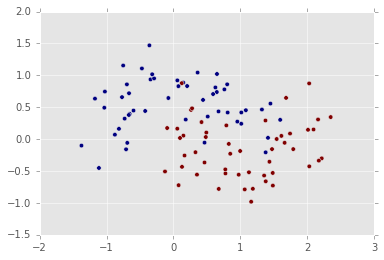

In [3]:
X, y = make_moons(noise=0.3, random_state=123)
plt.scatter(X[:,0], X[:,1], c=y)

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split

knn = KNeighborsClassifier(n_neighbors=10, weights='distance', metric='euclidean')
knn.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='distance')

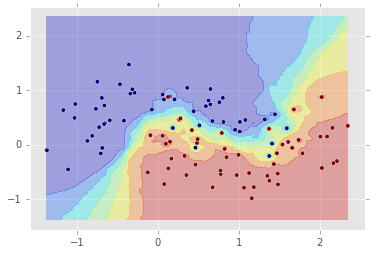

In [13]:
x_range = np.linspace(X.min(), X.max(), 100)
xx1, xx2 = np.meshgrid(x_range, x_range)

Y = knn.predict_proba(np.c_[xx1.ravel(), xx2.ravel()])[:,1]
Y = Y.reshape(xx1.shape)

plt.contourf(xx1, xx2, Y, alpha=0.3)
plt.scatter(X[:,0], X[:,1],c=y)

### Регрессия
Загрузите простой [датасет](https://www.dropbox.com/s/ow82e7paghozork/kengo.csv?dl=0) с измерениями носов(?) кенгуру. 
*Reference: Australian Journal of Zoology, Vol. 28, p607-613*

In [14]:
data = np.loadtxt('kengo.csv', skiprows=1, delimiter=',')
X = data[:,0].reshape(-1,1)
y = data[:,1]

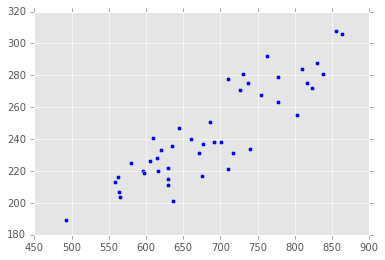

In [15]:
plt.scatter(X, y)

In [16]:
from sklearn.neighbors import KNeighborsRegressor

In [46]:
knn = KNeighborsRegressor(n_neighbors=5, weights='uniform', metric='euclidean')
knn.fit(X, y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='euclidean',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')

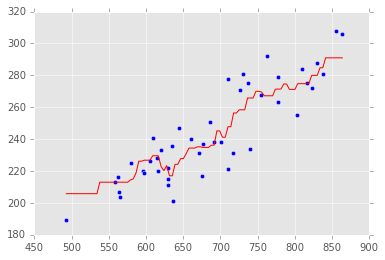

In [47]:
x_range = np.linspace(X.min(), X.max(), 100).reshape(-1,1)

y_hat = knn.predict(x_range)

plt.scatter(X, y)
plt.plot(x_range, y_hat, 'r')

# Задание 1
## Регрессия

Обучите метод ближайшего соседа на данных о стоимости апартаментов в Бостоне.<br/>
С помощью кросс-валидации определите оптимальное количество ближайших соседей и функцию расчета весов ближайших соседей

In [53]:
from sklearn.datasets import load_boston
data = load_boston()

In [54]:
print data['DESCR']

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [56]:
X = data.data
y = data.target

In [57]:
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler

In [61]:
from sklearn.metrics import mean_absolute_error

In [68]:
cv = KFold(X.shape[0], n_folds=3)

scores = []
for k in xrange(1,20):
    cv_score = []
    for train_idx, test_idx in cv:
        # Нормализация
        scaller = StandardScaler()

        X_train, y_train = X[train_idx], y[train_idx]

        X_train = scaller.fit_transform(X_train)

        # Обучили knn
        knn = KNeighborsRegressor(n_neighbors=k, weights='distance')
        knn.fit(X_train, y_train)

        # Предсказываем
        X_test, y_test = X[test_idx], y[test_idx]
        X_test = scaller.transform(X_test)
        y_hat = knn.predict(X_test)

        cv_score.append(mean_absolute_error(y_test, y_hat))
    scores.append(np.mean(cv_score))

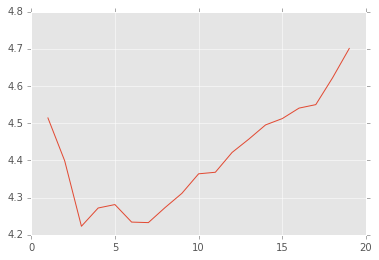

In [69]:
plt.plot(np.arange(1,20), scores)

## Классификация
Загрузите датасет с новостными текстами. Выберите 2 категории, разбейте документы на слова (n-gramm'ы), "обучите" метод ближайшего соседа для задачи категоризации текстов по их содержанию.

Используйте косинусную мету близости

In [70]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [71]:
news_docs = fetch_20newsgroups(subset='all', 
                               categories=['alt.atheism', 'comp.graphics'])

In [75]:
X = news_docs.data
y = news_docs.target

In [76]:
from sklearn.metrics import roc_auc_score

In [90]:
cv = KFold(len(X), n_folds=3)

scores = []
vect = CountVectorizer(stop_words='english')
X_bow = vect.fit_transform(X)        
for k in xrange(1,40):
    cv_score = []
    for train_idx, test_idx in cv:
        # Векторизация уже
        X_train, y_train = X_bow[train_idx], y[train_idx]

        # Обучили knn
        knn = KNeighborsClassifier(n_neighbors=k, weights='uniform', algorithm='brute',
                                   metric='cosine')
        knn.fit(X_train, y_train)

        # Предсказываем
        X_test, y_test = X_bow[test_idx], y[test_idx]
        y_hat = knn.predict_proba(X_test)

        cv_score.append(roc_aplt.plot(np.arange(1,40), scores)uc_score(y_test, y_hat[:,1]))
    scores.append(np.mean(cv_score))

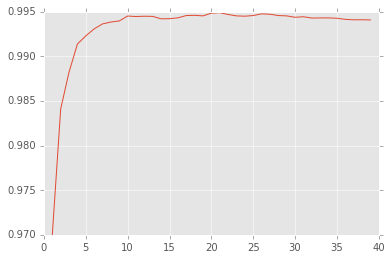

In [92]:
plt.plot(np.arange(1,40), scores)